# 权重衰减

上节讨论了过拟合现象，即模型的训练误差远小于它在测试集上的误差。虽然增大数据集可能会减轻过拟合，但是获得额外的训练数据往往代价高昂。下面介绍应对过拟合的常用方法：**权重衰减**（weight decay）

权重衰减等价于$L_{2}$范数**正则化**（regularization）。正则化的思想是在损失函数中增加刻画模型复杂度的指标，通过为模型损失函数添加惩罚项使得学出的模型参数较小，是应对过拟合的常用手段。  
假设用于刻画模型在训练数据集上的表现的损失函数为 $L(w)$，那么在优化时不直接优化 $L(w)$，而是优化 $L(w)+\lambda R(w)$，其中，$R(w)$ 就是用来刻画模型的复杂程度的，而$\lambda $ 表示模型复杂程度在总损失的比例。  
以线性回归中的损失函数  
$$l(w,b) = \frac{1}{n}\sum_{i=1}^{n}\frac{1}{2}(x^{i} w + b - y^{i})^{2}$$
为例，其中 $w$ 是权重参数，$b$ 是偏置参数，$x^{i}$ 为第 $i$ 个样本，标签为 $y^{i}$，样本总数为 $n$ ，则带有 $L_{2}$ 范数的惩罚项的新损失函数为  
$$ l(w,b) + \frac{\lambda}{2n}||w||^{2}$$  
在小批量的随机梯度下降中 $w$ 的迭代方式更改为  
$$ w \gets \bigg(1 - \frac{\eta \lambda}{|B|}\bigg)w - \frac{\eta}{|B|} \sum_{i\in B}x^{i}(x^{i}w + b - y^{i})$$  
其中， $\eta$ 为学习率。可见， $L_{2}$ 正则化令权重 $w$ 先乘小于 $1$ 的数，再减去不含惩罚项的梯度。因此， $L_{2}$ 范数的正则化又叫权重衰减。权重衰减通过惩罚绝对值较大的模型参数为需要学习的模型增加了限制，这可能对过拟合有效。实际场景中，我们有时也对惩罚项中添加偏差元素的平方和。

## 高维线性回归实验

下面，通过一个高维线性回归为例引入一个过拟合问题，并使用权重衰减来试着应对过拟合。
设数据样本特征维度为 $p$，对于训练数据集和测试数据集中的特征为 $x_{1},x_{2},...x_{p}$ 的任意一样本，我们使用如下的线性函数来生成该样本的标签：  
$$ y = 0.05 + \sum_{i=1}^{p}0.01x_{i} + \epsilon$$  
其中，噪音项服从均值为 $0$ 和标准差为$0.01$ 的正态分布。为了较容易的观察过拟合，我们考虑高维线性回归，设维度 $p=200$；同时，将训练数据集样本数设低，例如$20$

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = np.ones((num_inputs,1))*0.01, 0.05
features = np.random.randn(n_train+n_test, num_inputs)
labels = np.dot(features, true_w) + true_b
labels += 0.01 * np.random.randn(n_train+n_test,1)

# 产生训练集和测试集
train_features, test_features = features[:n_train,:], features[n_train:,:]
train_labels, test_labels = labels[:n_train], labels[n_train:]

## 权重衰减实现
通过在目标函数后面添加 $L_{2}$ 范数惩罚项来实现权重衰减。

### 定义模型参数

In [3]:
tf.set_random_seed(1)
w = tf.Variable(tf.random_normal(shape=[num_inputs,1]), dtype=tf.float32)
b = tf.Variable(tf.random_normal(shape=[1,]))

### 定义$L_{2}$范数惩罚项
这里只惩罚了模型的权重参数

In [4]:
def l2_penalty(w):
    return tf.reduce_mean((w**2))/2

### 定义训练和测试

In [47]:
num_epochs, lr = 100, 0.003
# 不使用权重衰减
lambd = 0

# Initialize placeholders
x = tf.placeholder(dtype=tf.float32, shape=[None,num_inputs])
y = tf.placeholder(dtype=tf.float32, shape=[None, 1])

# Declare model operations
prediction = tf.matmul(x,w) + b

# Declare loss function (L2 loss)
loss = tf.losses.mean_squared_error(y, prediction) + lambd * l2_penalty(w) 

# Declare optimizer
optimizer = tf.train.GradientDescentOptimizer(lr)
train_step = optimizer.minimize(loss)

# Create a graph session
sess = tf.Session()

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

In [48]:
# 训练和测试
train_ls = []
test_ls = []
for step in range(num_epochs):
    sess.run(train_step, feed_dict={x:train_features, y: train_labels})
    train_loss = sess.run(loss,feed_dict={x:train_features, y:train_labels})
    test_loss = sess.run(loss,feed_dict={x:test_features, y:test_labels})
    train_ls.append(train_loss)
    test_ls.append(test_loss)
    if step%20 == 0:
        print('step:',step,'|train_loss:',train_loss,'|test_loss:',test_loss)

step: 0 |train_loss: 238.384 |test_loss: 229.49263
step: 20 |train_loss: 19.708658 |test_loss: 222.38058
step: 40 |train_loss: 2.47939 |test_loss: 222.17108
step: 60 |train_loss: 0.38730204 |test_loss: 221.92088
step: 80 |train_loss: 0.066941924 |test_loss: 221.71434


### 定义loss画图函数

In [49]:
def plot_loss(x_vals, train_loss, test_loss, lambd):
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('lambda={}  Loss Analysis'.format(lambd))
    plt.yscale("log")
    plt.plot(x_vals, train_loss, color='red', label='train_loss')
    plt.plot(x_vals, test_loss, color='green', label='test_loss')
    plt.legend()

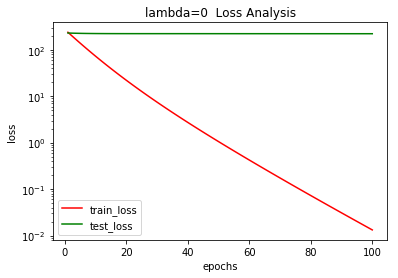

In [50]:
plot_loss(range(1,num_epochs+1),train_ls, test_ls, lambd)

In [51]:
num_epochs, lr = 100, 0.003

# 使用权重衰减
lambd = 300

# Initialize placeholders
x = tf.placeholder(dtype=tf.float32, shape=[None,num_inputs])
y = tf.placeholder(dtype=tf.float32, shape=[None, 1])

# Declare model operations
prediction = tf.matmul(x,w) + b

# Declare loss function (L2 loss)
loss = tf.losses.mean_squared_error(y, prediction) + lambd * l2_penalty(w)
# loss = tf.losses.mean_squared_error(y, prediction) + \
#         tf.contrib.layers.l2_regularizer(lambd)(w)

# Declare optimizer
optimizer = tf.train.GradientDescentOptimizer(lr)
train_step = optimizer.minimize(loss)

# Create a graph session
sess = tf.Session()

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

In [52]:
train_ls = []
test_ls = []
for step in range(num_epochs):
    sess.run(train_step, feed_dict={x:train_features, y: train_labels})
    train_loss = sess.run(loss,feed_dict={x:train_features, y:train_labels})
    test_loss = sess.run(loss,feed_dict={x:test_features, y:test_labels})
    train_ls.append(train_loss)
    test_ls.append(test_loss)
    if step%20 == 0:
        print('step:',step,'|train_loss:',train_loss,'|test_loss:',test_loss)

step: 0 |train_loss: 395.479 |test_loss: 386.80835
step: 20 |train_loss: 136.34079 |test_loss: 304.25333
step: 40 |train_loss: 101.01241 |test_loss: 252.91531
step: 60 |train_loss: 83.0316 |test_loss: 210.9466
step: 80 |train_loss: 69.1587 |test_loss: 176.04572


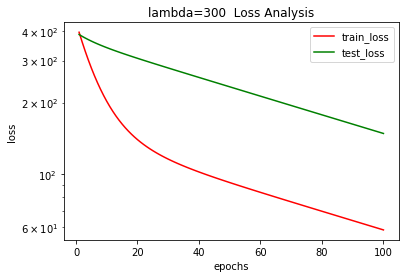

In [53]:
plot_loss(range(1,num_epochs+1),train_ls, test_ls, lambd)

## 小结
1. 正则化通过为模型损失函数添加惩罚项使得学出的模型参数值较小，是应对过拟合的常用手段。
2. 权重衰减等价于 $L_{2}$ 范数正则化，通常会使学到的权重参数的元素较接近于$0$

在贝叶斯统计中 
![image](./image/model_selection/l2.png)